This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Introduction to deep learning for computer vision

## Introduction to convnets

**Instantiating a small convnet**

In [1]:
from tensorflow import keras
from tensorflow.keras import layers
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

**Displaying the model's summary**

In [2]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 128)         73856 

**Training the convnet on MNIST images**

In [3]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28, 28, 1))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28, 28, 1))
test_images = test_images.astype("float32") / 255
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels, epochs=5, batch_size=64)

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/5
938/938 [==============================] - 14s 4ms/step - loss: 0.1506 - accuracy: 0.9527
Epoch 2/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0438 - accuracy: 0.9867
Epoch 3/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0312 - accuracy: 0.9904
Epoch 4/5
938/938 [==============================] - 4s 4ms/step - loss: 0.0229 - accuracy: 0.9930
Epoch 5/5
938/938 [==============================] - 5s 5ms/step - loss: 0.0183 - accuracy: 0.9945


**Evaluating the convnet**

In [4]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0333 - accuracy: 0.9898
Test accuracy: 0.990


### The convolution operation

#### Understanding border effects and padding

#### Understanding convolution strides

### The max-pooling operation

**An incorrectly structured convnet missing its max-pooling layers**

In [5]:
inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(inputs)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(10, activation="softmax")(x)
model_no_max_pool = keras.Model(inputs=inputs, outputs=outputs)

In [6]:
model_no_max_pool.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 128)       73856     
                                                                 
 flatten_1 (Flatten)         (None, 61952)             0         
                                                                 
 dense_1 (Dense)             (None, 10)                619530    
                                                                 
Total params: 712,202
Trainable params: 712,202
Non-trainab

## Training a convnet from scratch on a small dataset

### The relevance of deep learning for small-data problems

### Downloading the data

In [7]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ribakhan","key":"2cb4a7bc3a38aecc4d227f3f9ae26a8b"}'}

In [8]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:20<00:00, 42.2MB/s]
100% 812M/812M [00:20<00:00, 40.9MB/s]


In [10]:
!unzip -qq dogs-vs-cats.zip

In [11]:
!unzip -qq train.zip

# Question-1

Consider the Cats & Dogs example. Start initially with a training sample of 1000, a validation sample of 500, and a test sample of 500 (like in the text). Use any technique to reduce overfitting and improve performance in developing a network that you train from scratch. What performance did you achieve?

Creating a convolutional network. Here we are diving the data into test, 
train and validation as mentioned in the question.

In [12]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("test", start_index=0, end_index=500)
make_subset("validation", start_index=500, end_index=1000)
make_subset("train", start_index=1000, end_index=2000)

### Building the model

**Instantiating a small convnet for dogs vs. cats classification**

In [19]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [17]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_11 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                       

Total parameteres turned out to be 991,041.
Parameters in general are weights that are learnt during training.

**Configuring the model for training**

In [20]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

### Data preprocessing

**Using `image_dataset_from_directory` to read images**

Modifying the images to tensors.


In [21]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [22]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [23]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [24]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [25]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


**Displaying the shapes of the data and labels yielded by the `Dataset`**

In [26]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


**Fitting the model using a `Dataset`**

The reason we are using "callbacks" here is beacuse 
Callbacks can help  prevent overfitting, visualize training progress and create a TensorBoard, etc. In order to avoid having to retrain the model, we will employ "callbacks," which will automatically save a file with the weights produced from the best epoch. 

Using only 30 epochs here. 

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
63/63 [==============================] - 8s 81ms/step - loss: 0.7045 - accuracy: 0.5230 - val_loss: 0.6811 - val_accuracy: 0.5620
Epoch 2/30
63/63 [==============================] - 5s 72ms/step - loss: 0.6967 - accuracy: 0.5445 - val_loss: 0.6757 - val_accuracy: 0.5770
Epoch 3/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6758 - accuracy: 0.6070 - val_loss: 0.6694 - val_accuracy: 0.5890
Epoch 4/30
63/63 [==============================] - 5s 71ms/step - loss: 0.6544 - accuracy: 0.6360 - val_loss: 0.6398 - val_accuracy: 0.6260
Epoch 5/30
63/63 [==============================] - 5s 78ms/step - loss: 0.6143 - accuracy: 0.6655 - val_loss: 0.6858 - val_accuracy: 0.6200
Epoch 6/30
63/63 [==============================] - 5s 72ms/step - loss: 0.5907 - accuracy: 0.6875 - val_loss: 0.6013 - val_accuracy: 0.6890
Epoch 7/30
63/63 [==============================] - 5s 71ms/step - loss: 0.5405 - accuracy: 0.7285 - val_loss: 0.7835 - val_accuracy: 0.6560
Epoch 8/30
63

Validation accuracy 73%.

**Displaying curves of loss and accuracy during training**

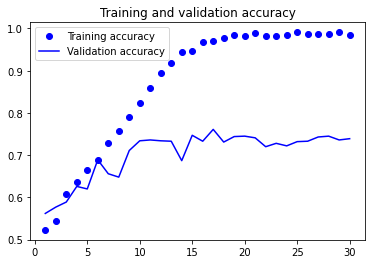

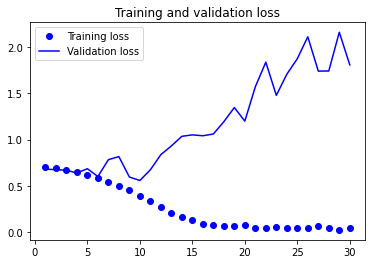

In [28]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

**Evaluating the model on the test set**

In [29]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.5290 - accuracy: 0.7420
Test accuracy: 0.742


The accuracy turns out to be 74% which is not fairly very high. Next I will perform additional steps to improve model perfomance.

Now, in order to improve model performance I will use the dropout method. Using a dropout layer of 0.5

Including dropout in a new convent

In [30]:
inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)



Compiling model


In [31]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


Now training the convent


Here, i am using only 50 epochs due to time constraint.

In [32]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 6s 83ms/step - loss: 0.7175 - accuracy: 0.5145 - val_loss: 0.6920 - val_accuracy: 0.5030
Epoch 2/50
63/63 [==============================] - 5s 78ms/step - loss: 0.6991 - accuracy: 0.5400 - val_loss: 0.6714 - val_accuracy: 0.5710
Epoch 3/50
63/63 [==============================] - 5s 74ms/step - loss: 0.6872 - accuracy: 0.6045 - val_loss: 0.6522 - val_accuracy: 0.6340
Epoch 4/50
63/63 [==============================] - 5s 74ms/step - loss: 0.6883 - accuracy: 0.6435 - val_loss: 0.6144 - val_accuracy: 0.6810
Epoch 5/50
63/63 [==============================] - 5s 72ms/step - loss: 0.6255 - accuracy: 0.6735 - val_loss: 0.6829 - val_accuracy: 0.5960
Epoch 6/50
63/63 [==============================] - 5s 72ms/step - loss: 0.5888 - accuracy: 0.6815 - val_loss: 0.5931 - val_accuracy: 0.6950
Epoch 7/50
63/63 [==============================] - 5s 74ms/step - loss: 0.5547 - accuracy: 0.7260 - val_loss: 0.6455 - val_accuracy: 0.6510
Epoch 8/50
63

Validation accuracy turns out to be 73%

In [33]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_dropout.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 38ms/step - loss: 0.5150 - accuracy: 0.7400
Test accuracy: 0.740


The second method i will be using to improve the model performance is using data augmentaion technique combining with dropout function

In [34]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

including image augmentation and dropout


In [35]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

training the model 

I am using only 50 epochs here.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation_dropout.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 8s 99ms/step - loss: 0.8148 - accuracy: 0.5115 - val_loss: 0.6910 - val_accuracy: 0.6090
Epoch 2/50
63/63 [==============================] - 6s 95ms/step - loss: 0.6953 - accuracy: 0.5215 - val_loss: 0.6861 - val_accuracy: 0.5050
Epoch 3/50
63/63 [==============================] - 6s 97ms/step - loss: 0.6917 - accuracy: 0.5655 - val_loss: 0.9714 - val_accuracy: 0.5020
Epoch 4/50
63/63 [==============================] - 7s 108ms/step - loss: 0.6759 - accuracy: 0.6105 - val_loss: 0.6846 - val_accuracy: 0.5470
Epoch 5/50
63/63 [==============================] - 6s 97ms/step - loss: 0.6769 - accuracy: 0.6325 - val_loss: 0.6365 - val_accuracy: 0.6440
Epoch 6/50
63/63 [==============================] - 6s 96ms/step - loss: 0.6278 - accuracy: 0.6485 - val_loss: 0.6075 - val_accuracy: 0.6780
Epoch 7/50
63/63 [==============================] - 6s 96ms/step - loss: 0.6102 - accuracy: 0.6790 - val_loss: 0.8473 - val_accuracy: 0.5230
Epoch 8/50
6

Validation accuracy turns out to be 81% which is improved by 8% than before.

#Question 2
Increase your training sample size. You may pick any amount. Keep the validation and test 
samples the same as above. Optimize your network (again training from scratch). What 
performance did you achieve? 

In [36]:
make_subset("train3", start_index=1000, end_index=6000)

train_dataset_3 = image_dataset_from_directory(
    new_base_dir / "train3",
    image_size=(180, 180),
    batch_size=32)

Found 10000 files belonging to 2 classes.


I have increased the training sample size to 5000.

In [37]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

Training the regularized convent. I am using 60 epochs here.

In [38]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset_3,
    epochs=70,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/70
313/313 [==============================] - 20s 61ms/step - loss: 0.6701 - accuracy: 0.5854 - val_loss: 0.5842 - val_accuracy: 0.6880
Epoch 2/70
313/313 [==============================] - 20s 62ms/step - loss: 0.5805 - accuracy: 0.6953 - val_loss: 0.5611 - val_accuracy: 0.7110
Epoch 3/70
313/313 [==============================] - 21s 66ms/step - loss: 0.5080 - accuracy: 0.7641 - val_loss: 0.4805 - val_accuracy: 0.7860
Epoch 4/70
313/313 [==============================] - 23s 71ms/step - loss: 0.4353 - accuracy: 0.7988 - val_loss: 0.5358 - val_accuracy: 0.7240
Epoch 5/70
313/313 [==============================] - 20s 63ms/step - loss: 0.3874 - accuracy: 0.8300 - val_loss: 0.4618 - val_accuracy: 0.7740
Epoch 6/70
313/313 [==============================] - 21s 67ms/step - loss: 0.3286 - accuracy: 0.8579 - val_loss: 0.6649 - val_accuracy: 0.7310
Epoch 7/70
313/313 [==============================] - 21s 66ms/step - loss: 0.2815 - accuracy: 0.8795 - val_loss: 0.3129 - val_accuracy:

Validation accuracy turns out to be 88%

Checking the model accuracy


In [39]:
test_model = keras.models.load_model(
    "convnet_from_scratch3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 50ms/step - loss: 0.3202 - accuracy: 0.8760
Test accuracy: 0.876


Question 3: Now change your training sample so that you achieve better performance than those from Steps 
1 and 2. This sample size may be larger, or smaller than those in the previous steps. The  objective is to find the ideal training sample size to get best prediction results.

In [40]:
#import shutil
#shutil.rmtree('/content/cats_vs_dogs_small/train2')

make_subset("train2", start_index=1000, end_index=11000)

train_dataset2 = image_dataset_from_directory(
    new_base_dir / "train2",
    image_size=(180, 180),
    batch_size=32)

Found 20000 files belonging to 2 classes.


In [41]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
#x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [42]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_test3.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset_3,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
313/313 [==============================] - 22s 66ms/step - loss: 0.7123 - accuracy: 0.5672 - val_loss: 0.6220 - val_accuracy: 0.6680
Epoch 2/50
313/313 [==============================] - 22s 68ms/step - loss: 0.5874 - accuracy: 0.6945 - val_loss: 0.5372 - val_accuracy: 0.7360
Epoch 3/50
313/313 [==============================] - 22s 69ms/step - loss: 0.5009 - accuracy: 0.7626 - val_loss: 0.5055 - val_accuracy: 0.7570
Epoch 4/50
313/313 [==============================] - 23s 71ms/step - loss: 0.4375 - accuracy: 0.8030 - val_loss: 0.4316 - val_accuracy: 0.8020
Epoch 5/50
313/313 [==============================] - 22s 69ms/step - loss: 0.3847 - accuracy: 0.8281 - val_loss: 0.4240 - val_accuracy: 0.8080
Epoch 6/50
313/313 [==============================] - 21s 67ms/step - loss: 0.3202 - accuracy: 0.8627 - val_loss: 0.4142 - val_accuracy: 0.8190
Epoch 7/50
313/313 [==============================] - 23s 71ms/step - loss: 0.2658 - accuracy: 0.8894 - val_loss: 0.4521 - val_accuracy:

Check model accuracy

In [43]:
test_model = keras.models.load_model(
    "convnet_from_scratch_test3.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 37ms/step - loss: 0.4147 - accuracy: 0.8340
Test accuracy: 0.834


In [44]:
inputs = keras.Input(shape=(180, 180, 3))

x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


Training regularized convent

In [47]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch2.keras",
        save_best_only=True,
        monitor="val_loss")
]

history = model.fit(
    train_dataset2,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
625/625 [==============================] - 38s 58ms/step - loss: 0.6089 - accuracy: 0.6711 - val_loss: 0.5986 - val_accuracy: 0.6970
Epoch 2/30
625/625 [==============================] - 34s 55ms/step - loss: 0.4786 - accuracy: 0.7715 - val_loss: 0.4153 - val_accuracy: 0.8040
Epoch 3/30
625/625 [==============================] - 34s 54ms/step - loss: 0.3925 - accuracy: 0.8255 - val_loss: 0.3619 - val_accuracy: 0.8400
Epoch 4/30
625/625 [==============================] - 34s 54ms/step - loss: 0.3212 - accuracy: 0.8591 - val_loss: 0.3567 - val_accuracy: 0.8400
Epoch 5/30
625/625 [==============================] - 35s 56ms/step - loss: 0.2722 - accuracy: 0.8849 - val_loss: 0.3925 - val_accuracy: 0.8420
Epoch 6/30
625/625 [==============================] - 34s 55ms/step - loss: 0.2287 - accuracy: 0.9033 - val_loss: 0.3103 - val_accuracy: 0.8990
Epoch 7/30
625/625 [==============================] - 34s 54ms/step - loss: 0.2005 - accuracy: 0.9183 - val_loss: 0.2236 - val_accuracy:

Now evelauting the test data

In [48]:
test_model = keras.models.load_model(
    "convnet_from_scratch2.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 2s 36ms/step - loss: 0.2422 - accuracy: 0.9170
Test accuracy: 0.917


Question 4: Repeat Steps 1-3, but now using a pretrained network. The sample sizes you use in Steps 2 and 3 
for the pretrained network may be the same or different from those using the network where  you trained from scratch. Again, use any and all optimization techniques to get best 
performance.  

Using pre trained model. Using the VGG16 convolution base.
Here using 1000 samples.

In [49]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [50]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [51]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

In [52]:

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [53]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

In [54]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
63/63 [==============================] - 25s 337ms/step - loss: 3.9529 - accuracy: 0.7200 - val_loss: 0.9018 - val_accuracy: 0.8890
Epoch 2/20
63/63 [==============================] - 14s 216ms/step - loss: 1.0367 - accuracy: 0.8570 - val_loss: 0.4505 - val_accuracy: 0.9330
Epoch 3/20
63/63 [==============================] - 14s 226ms/step - loss: 0.4728 - accuracy: 0.9180 - val_loss: 0.3457 - val_accuracy: 0.9460
Epoch 4/20
63/63 [==============================] - 14s 217ms/step - loss: 0.3889 - accuracy: 0.9170 - val_loss: 0.2584 - val_accuracy: 0.9580
Epoch 5/20
63/63 [==============================] - 14s 219ms/step - loss: 0.2496 - accuracy: 0.9260 - val_loss: 0.2472 - val_accuracy: 0.9580
Epoch 6/20
63/63 [==============================] - 14s 218ms/step - loss: 0.2236 - accuracy: 0.9415 - val_loss: 0.2464 - val_accuracy: 0.9630
Epoch 7/20
63/63 [==============================] - 14s 217ms/step - loss: 0.2079 - accuracy: 0.9505 - val_loss: 0.2101 - val_accuracy: 0.9660

In [55]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 105ms/step - loss: 0.1480 - accuracy: 0.9770
Test accuracy: 0.977


Pre trained model - 10000 samples 

In [56]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [57]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)

conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [58]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning3.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset2,
    epochs=20,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/20
625/625 [==============================] - 104s 164ms/step - loss: 0.8159 - accuracy: 0.8984 - val_loss: 0.1589 - val_accuracy: 0.9680
Epoch 2/20
625/625 [==============================] - 105s 167ms/step - loss: 0.1522 - accuracy: 0.9514 - val_loss: 0.1457 - val_accuracy: 0.9790
Epoch 3/20
625/625 [==============================] - 104s 166ms/step - loss: 0.1170 - accuracy: 0.9618 - val_loss: 0.1341 - val_accuracy: 0.9810
Epoch 4/20
625/625 [==============================] - 104s 166ms/step - loss: 0.0936 - accuracy: 0.9682 - val_loss: 0.1215 - val_accuracy: 0.9840
Epoch 5/20
625/625 [==============================] - 105s 168ms/step - loss: 0.0880 - accuracy: 0.9712 - val_loss: 0.1294 - val_accuracy: 0.9830
Epoch 6/20
625/625 [==============================] - 104s 166ms/step - loss: 0.0815 - accuracy: 0.9735 - val_loss: 0.1441 - val_accuracy: 0.9830
Epoch 7/20
625/625 [==============================] - 105s 168ms/step - loss: 0.0816 - accuracy: 0.9728 - val_loss: 0.1612 -

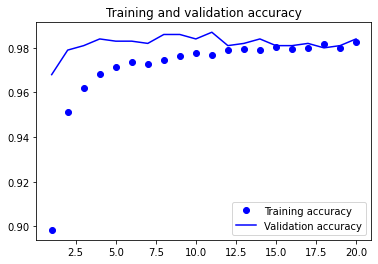

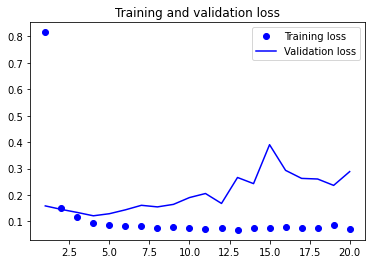

In [59]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [60]:
model = keras.models.load_model("fine_tuning3.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 110ms/step - loss: 0.0866 - accuracy: 0.9860
Test accuracy: 0.986


# SUMMARY

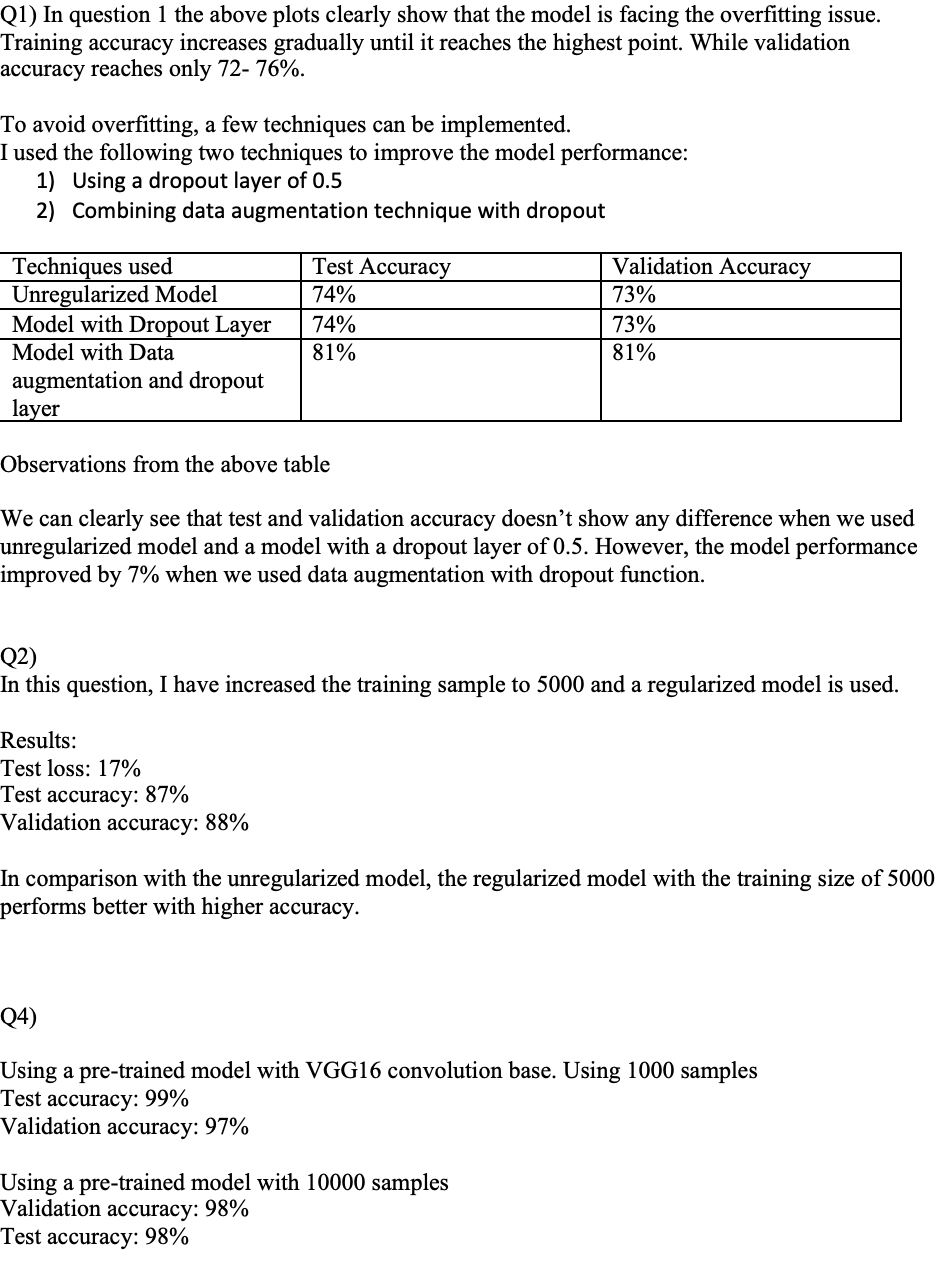

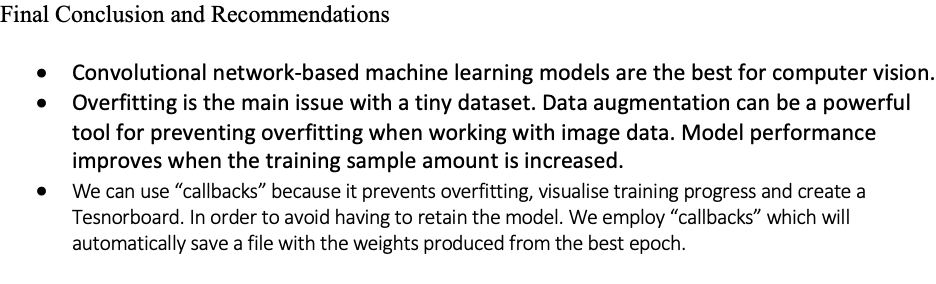